In [1]:
import pickle
import random
import time
from math import ceil
from typing import List
from typing import Set
from typing import Tuple

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from torch import Tensor
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

from evaluation import MyPredictionModel
from evaluation import evaluate_graphs
from graph import Graph
from mapping import FamilyIdMapping
from node import Node
from part import Part
from utils import load_graphs

Load graphs dataset, shuffle it and split it into training, validation and test set.

In [2]:
graphs = load_graphs()
seed = 7
random.Random(seed).shuffle(graphs)

training_set_size_ratio = 0.8
validation_set_size_ratio = 0.03
test_size_ratio = 0.17

assert training_set_size_ratio + test_size_ratio + validation_set_size_ratio == 1

# Dense Family ID Mapping
All parts have a family that lies between 0 and 95 (inclusive). However, some family IDs, like 16, don't appear in the dataset. We create a dense family ID mapping and use dense family IDs to shorten our model's feature vector. For example, family ID 17 is converted to dense Family ID 16 due to the gap Family ID 16 left.

In [3]:
fam_mapping = FamilyIdMapping(graphs)


def get_ofid(self):
    """
    :return: the original family if of the node's part
    """
    return int(self.get_family_id())


def get_dfid(self):
    """
    :return: the dense family if of the node's part
    """
    return fam_mapping.to_dense(self.get_ofid())


# Add extension functions to nodes to make code easier to read
Part.get_ofid = get_ofid
Part.get_dfid = get_dfid

# Model Hyperparameters

In [4]:
batch_size = 1024

input_size = 2 * len(fam_mapping)  # 184
output_size = len(fam_mapping)  # 92

input_size = input_size
hidden_size = 2 * input_size
output_size = output_size

learning_rate = 0.003
num_epochs = 50


# Our Model

It is a simple Feedforward neural network consisting of just one hidden layer. The model does not directly predict the edges for a set of parts. Instead, it predicts all the neighbors of one node of a Graph.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

## Model Features

The model takes a 1D tensor that can be divided into two parts `all_nodes_tensor` (first half) and `given_node_tensor` (second half):
- `all_nodes_tensor`: one-hot encoded dense family IDs for each part that we should use to build the graph. E.g., (1,0,3,0,...,0) means that the graph consists of one part with dense family ID 0 and three parts with dense family ID 2.
- `given_node_tensor`: one-hot encoded dense family ID for which the model should predict its neighbors. E.g., (0,0,1,0,...,0) means that the model should predict the neighbors of all parts with dense family id 2.

In [6]:
def create_features(parts: Set[Part], fam_mapping: FamilyIdMapping) -> List[Tensor]:
    parts_sorted = list(parts)
    parts_sorted.sort()

    num_different_family_ids = len(fam_mapping)

    all_nodes_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)

    for part in parts_sorted:
        dense_family_id = part.get_dfid()
        all_nodes_tensor[dense_family_id] += 1.0

    feature_tensors = []

    for part in parts_sorted:
        dense_family_id = part.get_dfid()
        given_node_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)
        given_node_tensor[dense_family_id] = 1
        feature_tensor = torch.cat((all_nodes_tensor, given_node_tensor), dim=-1)
        feature_tensors.append(feature_tensor)

    return feature_tensors


## Model Labels

The model outputs a 1D tensor that represents the neighbors of a given node. E.g., (1,0,1,0,...,0) means that the given node (only) has two neighbors: one with dense family ID 0 and one with dense family ID 2

In [7]:
def create_labels(graph: Graph, fam_mapping: FamilyIdMapping) -> List[Tensor]:
    label_tensors = []

    num_different_family_ids = len(fam_mapping)
    edges = graph.get_edges()

    for node in sorted(graph.get_nodes()):
        target_tensor = torch.zeros(num_different_family_ids, dtype=torch.float)
        for neighbour_node in edges[node]:
            neighbour_node_dense_family_id = neighbour_node.get_part().get_dfid()
            target_tensor[neighbour_node_dense_family_id] = 1
        label_tensors.append(target_tensor)
    return label_tensors

## GraphDataset

We split the dataset into train, val and test sets.

In [8]:
train_upper = ceil(training_set_size_ratio * len(graphs))
val_upper = ceil((training_set_size_ratio + validation_set_size_ratio) * len(graphs))

train_graphs = graphs[0:train_upper]
val_graphs = graphs[train_upper:val_upper]
test_graphs = graphs[val_upper:len(graphs) + 1]

def create_features_and_labels(graph: Graph, fam_mapping: FamilyIdMapping) -> Tuple[List[Tensor], List[Tensor]]:
    feature_tensors = create_features(graph.get_parts(), fam_mapping)
    label_tensors = create_labels(graph, fam_mapping)
    return feature_tensors, label_tensors

class GraphDataset(Dataset):
    def __init__(self, graphs: List[Graph]):
        x_list = []
        y_list = []
        for graph in graphs:
            x_per_graph, y_per_graph = create_features_and_labels(graph, fam_mapping)
            x_list += x_per_graph
            y_list += y_per_graph
        self.x_tensor = torch.stack(x_list)
        self.y_tensor = torch.stack(y_list)
        self.n_samples = self.y_tensor.shape[0]

    def __getitem__(self, index):
        return self.x_tensor[index], self.y_tensor[index]

    def __len__(self):
        return self.n_samples


train_loader = DataLoader(
    dataset=GraphDataset(train_graphs),
    batch_size=batch_size,
    shuffle=True,
)
val_loader = DataLoader(
    dataset=GraphDataset(val_graphs),
    batch_size=batch_size,
    shuffle=False,
)

# Training

In [9]:
st = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
model = Net().to(device)
n_total_steps = len(train_loader)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()
train_losses = []
val_losses = []

train_accuracies = []
val_accuracies = []

for epoch in tqdm(range(num_epochs), ascii="░▒█"):
    train_losses_per_epoch = 0.0
    train_accuracy_per_epoch = 0.0
    for i, (x_train, y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(x_train)
        loss = loss_fn(y_pred, y_train)
        train_losses_per_epoch += loss.cpu().detach().numpy()
        train_accuracy = torch.sum(y_train == y_pred.round()) / torch.numel(y_train)
        train_accuracy_per_epoch += train_accuracy.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(train_losses_per_epoch / len(train_loader))
    train_accuracies.append(train_accuracy_per_epoch / len(train_loader))

    with torch.no_grad():
        val_losses_per_epoch = 0.0
        val_accuracies_per_epoch = 0.0
        for i, (x_val, y_val) in enumerate(val_loader):
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            y_pred = model(x_val)
            loss = loss_fn(y_pred, y_val)
            val_accuracy = torch.sum(y_val == y_pred.round()) / torch.numel(y_val)
            val_losses_per_epoch += loss.cpu()
            val_accuracies_per_epoch += val_accuracy.cpu()
        val_losses.append(val_losses_per_epoch / len(val_loader))
        val_accuracies.append(val_accuracies_per_epoch / len(val_loader))

et = time.time()
print(f"Execution time: {(et - st):.2f}s")

100%|██████████| 50/50 [00:36<00:00,  1.39it/s]

Execution time: 36.12s


## Learning Progress Plot

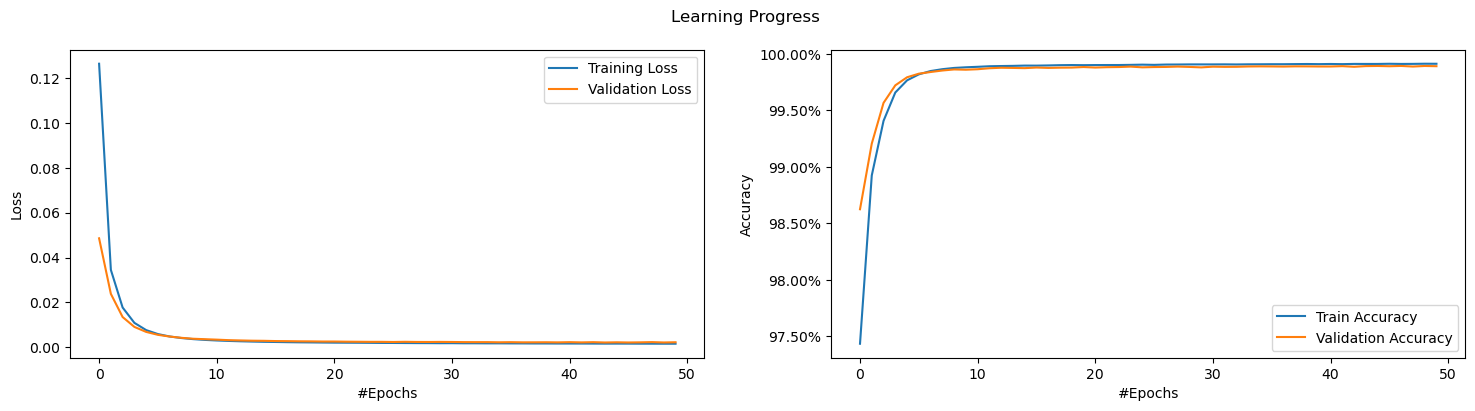

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 4))

ax1.set(xlabel='#Epochs', ylabel='Loss')
fig.suptitle('Learning Progress')
ax1.plot(train_losses, label="Training Loss")
ax1.plot(val_losses, label="Validation Loss")
ax1.legend()

ax2.set(xlabel='#Epochs', ylabel='Accuracy')
ax2.plot(train_accuracies, label="Train Accuracy")
ax2.plot(val_accuracies, label="Validation Accuracy")
ax2.legend()
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))

# Evaluation

In [11]:
cpu_model = model.cpu()


def check_for_cycle(graph: Graph, source: Part, sink: Part):
    graph.add_undirected_edge(source, sink)
    return graph.is_cyclic()


def get_parts_with_fam_id(parts: List[Part], fam_id: int) -> List[Part]:
    return [part for part in parts if part.get_ofid() == fam_id]


def get_least_fam_id_neighbours_node(graph: Graph, nodes: List[Node], fam_id: int) -> Node:
    balance_counts = [0] * len(nodes)
    for i, node in enumerate(nodes):
        edges = graph.get_edges().get(node)
        if edges is not None:
            balance_counts[i] = \
                sum(1 if n.get_ofid() == fam_id else 0 for n in edges)

    balanced_node_idx: int = np.array(balance_counts).argmin()
    node = nodes[balanced_node_idx]
    return node


class KantenKennerKarl(MyPredictionModel):

    def __init__(self, model, fam_mapping):
        self.model = model
        self.fam_mapping = fam_mapping

    def predict_graph(self, parts: Set[Part]) -> Graph:
        raw_predictions = []
        feature_tensors = create_features(parts, self.fam_mapping)
        for feature_tensor in feature_tensors:
            prediction = self.model(feature_tensor)
            raw_predictions.append(prediction)
        raw_predictions = torch.stack(raw_predictions)
        return self.build_predicted_graph(parts, raw_predictions)

    def build_predicted_graph(self, parts: Set[Part], pred_adj_matrix: Tensor) -> Graph:
        parts_list = sorted(list(parts))
        added_parts = set()
        node_count = len(parts_list)
        predicted_graph = Graph()

        while predicted_graph.get_edge_count() // 2 < node_count - 1 and not torch.all(pred_adj_matrix < 1e-3):

            max_signal_idx = (pred_adj_matrix == torch.max(pred_adj_matrix)).nonzero()
            source_idx = max_signal_idx[0][0].item()
            sink_dense_fam_id = max_signal_idx[0][1].item()

            source_orig_fam_id = parts_list[source_idx].get_ofid()
            sink_orig_fam_id = self.fam_mapping.to_orig(sink_dense_fam_id)

            parts_with_source_fam_id = get_parts_with_fam_id(parts_list, source_orig_fam_id)
            parts_with_sink_fam_id = get_parts_with_fam_id(parts_list, sink_orig_fam_id)

            for source in parts_with_source_fam_id:
                for sink in parts_with_sink_fam_id:
                    if source != sink and not (source in added_parts and sink in added_parts):
                        predicted_graph.add_undirected_edge(source, sink)
                        added_parts.add(source)
                        added_parts.add(sink)
                        break

            pred_adj_matrix[source_idx][sink_dense_fam_id] = 0.0
        return predicted_graph


predictor = KantenKennerKarl(cpu_model, fam_mapping)

with torch.no_grad():
    st = time.time()
    accuracy = evaluate_graphs(predictor, val_graphs)
    print(f"Mean normalized edge accuracy: {accuracy}")
    et = time.time()
    print(f"Execution time: {(et - st):.2f}s")

100%|██████████| 334/334 [00:14<00:00, 23.23it/s]

Mean normalized edge accuracy: 0.871236546905797
Execution time: 14.38s


Save prediction model

In [12]:
with open('data/karl.dat', 'wb') as file:
    pickle.dump(predictor, file=file)